## EDA

This notebook accomplishes the following:
* Applies a 20-day rolling window mean to data to represent monthly scale without reducing our availble data points too much.

For the 20-day data:
* Evaluates pairwise relationships between all features
* Computes correlation matrix for all features
* Investigates the distributions and autocorrelation within macro and equity styles categories

In [18]:
import numpy as np
import pandas as pd
import openpyxl
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
# Load dataframes from pickle file
with open('data_clean.pkl', 'rb') as f:
    saved = pickle.load(f)
    price_df = saved['price_df']
    return_df = saved['return_df']
    category_map = saved['category_mapping']


In [20]:
# Looking at returns as it will be our main focus for our project
return_df.head()

us_dollar  commodities  us_equity     value  small_cap   low_vol  \
date                                                                           
2015-05-01   0.007651    -0.003950   0.010562  0.008450   0.006205  0.007597   
2015-05-04   0.002041     0.000463   0.003016  0.004505   0.003037  0.003479   
2015-05-05  -0.004559     0.014689  -0.011888 -0.010159  -0.011492 -0.012564   
2015-05-06  -0.010851     0.000822  -0.003583 -0.003846   0.002169 -0.002760   
2015-05-07   0.006034    -0.021568   0.004026  0.001870   0.004883  0.006183   

              credit  interest_rate  long_vol  momentum  inflation   bitcoin  \
date                                                                           
2015-05-01 -0.000170      -0.012842 -0.135989  0.016890  -0.009783 -0.010498   
2015-05-04  0.000623      -0.008929  0.011742  0.002671  -0.003986  0.015548   
2015-05-05  0.000226      -0.001959  0.107615 -0.015870   0.013180 -0.015229   
2015-05-06 -0.001189      -0.015421  0.057042 -0.000690  -0.007915  0.002554   
2015-05-07 -0.000359       0.011479 -0.001321  0.008361  -0.017738  0.006991   

             quality     trend    equity  em_equity  
date                                                 
2015-05-01  0.014540  0.005873  0.005056  -0.001684  
2015-05-04  0.001143  0.002962  0.002135   0.002231  
2015-05-05 -0.010659 -0.009874 -0.009612  -0.000228  
2015-05-06 -0.002461 -0.009081 -0.000062  -0.007123  
2015-05-07  0.005120 -0.001810 -0.001627  -0.014961

In [21]:
print("Column Names:",return_df.columns)
print("\nCategories of Assets:", category_map)
print("Shape:", return_df.shape)

Column Names: Index(['us_dollar', 'commodities', 'us_equity', 'value', 'small_cap',
       'low_vol', 'credit', 'interest_rate', 'long_vol', 'momentum',
       'inflation', 'bitcoin', 'quality', 'trend', 'equity', 'em_equity'],
      dtype='object')

Categories of Assets: {'core_macro': ['commodities', 'credit', 'interest_rate', 'equity'], 'secondary_macro': ['us_dollar', 'us_equity', 'inflation', 'bitcoin', 'em_equity'], 'macro_styles': ['trend', 'long_vol'], 'equity_styles': ['value', 'small_cap', 'low_vol', 'momentum', 'quality']}
Shape: (2530, 16)


In [22]:
# There are 20 trading days in a month. Since daily returns are not as meaningful for the context of financial assets, we want to transform our data points to be on a monthly scale.

# Compute 20-day rolling mean for each asset
return_df_20day = return_df.rolling(window=20).mean()
print("Shape after 20 day rolling window:", return_df_20day.shape)

# Check to see if rolling window application worked
print(return_df_20day.head(21))

# Now for a particular row for a date represents the mean value for the previous 20 days.

Shape after 20 day rolling window: (2530, 16)
            us_dollar  commodities  us_equity     value  small_cap   low_vol  \
date                                                                           
2015-05-01        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-04        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-05        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-06        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-07        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-08        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-11        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-12        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-13        NaN          NaN        NaN       NaN        NaN       NaN   
2015-05-14        NaN          NaN        NaN       NaN        NaN       N

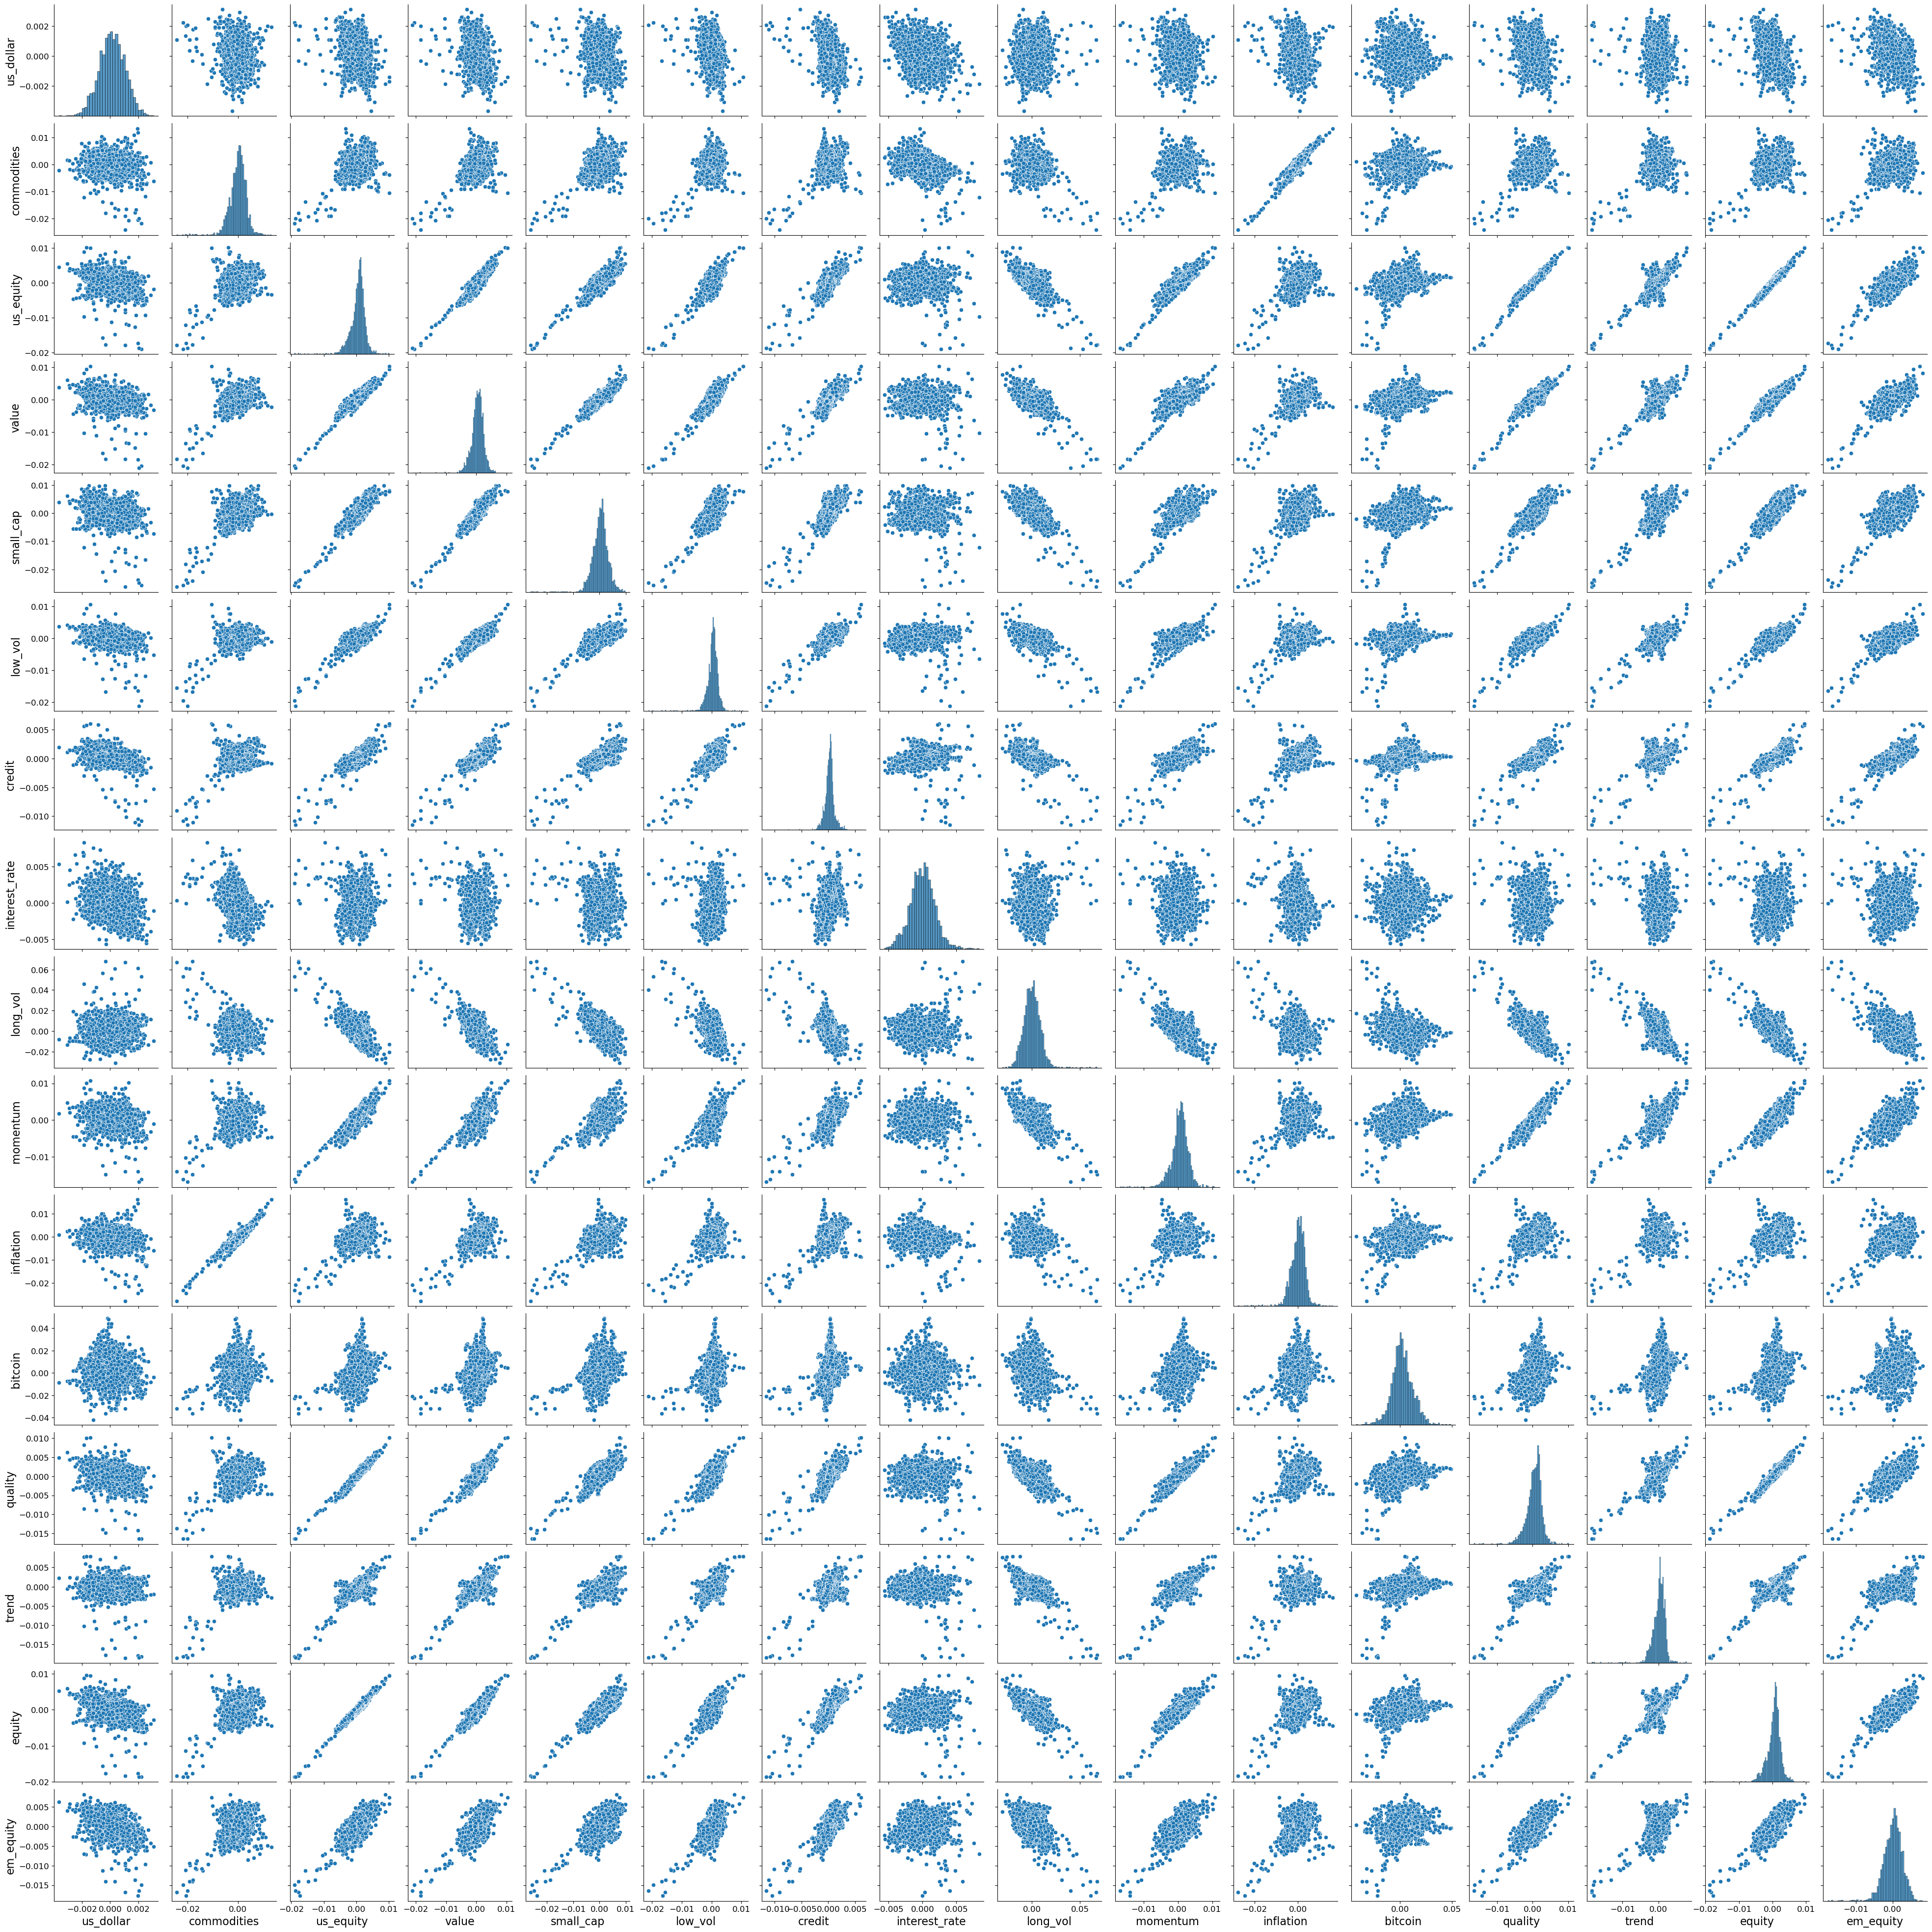

In [23]:
#Plot pairplot for all features
g = sns.pairplot(return_df_20day)

for ax in g.axes.flatten():
    ax.tick_params(labelsize=12)  # Change tick label size
    ax.xaxis.label.set_size(16)   # Change x-axis label size
    ax.yaxis.label.set_size(16)   # Change y-axis label size

Compared to our daily returns pairplot, we are seeing tighter scatter patterns, which will help our GMM model with defining more distinct clusters and reduce outlier influence.

We will still look at our correlation matrix to make a measure that will help us decide which features to drop due to redunancy.

Still there is lack of distinct multi-modal patterns between pairwise features, so we will use GMM to see if there are clusters in higher dimensions.

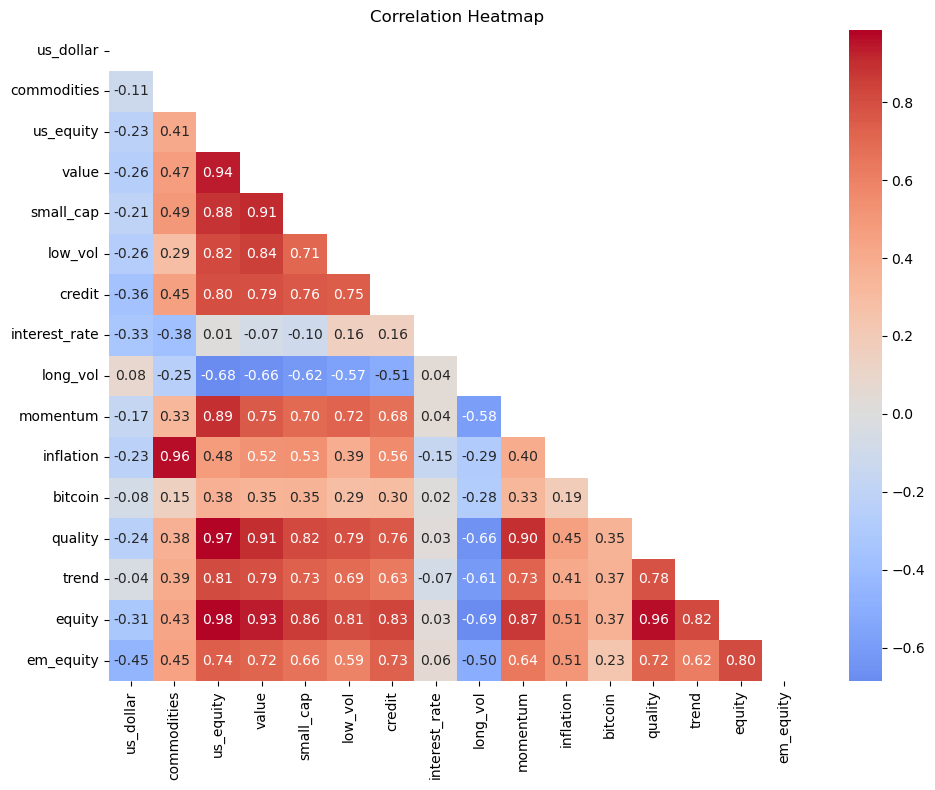

In [27]:
# Compute the correlation matrix
corr_matrix = return_df_20day.corr()

# Plot the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

The correlation matrix gives a much clearer picture on highly correlated features, which can point to redundant features we can consider dropping or transforming for our model.

Some of the most highly correlated pairs include: (> 0.90, or < -0.90)
* quality & us_equity (0.97) delta (-0.01)
* equity & us_equity (0.98) delta (+0.02)
* value & us_equity (0.94) delta (-0.01)
* inflation & commodities (0.96) delta (+0.01)
* equity & quality (0.96) delta (+0.03)
* ~~momentum & us_equity~~ (0.89) delta (-0.03)
* quality & value (0.91) delta (-0.01)
* quality & momentum (0.90) delta (-0.02)
* equity & value (0.93) delta (+0.02)
* small_cap & value (0.91) delta (+0.01)

deltas are based on the correlation data from daily returns



Macro Styles Features:


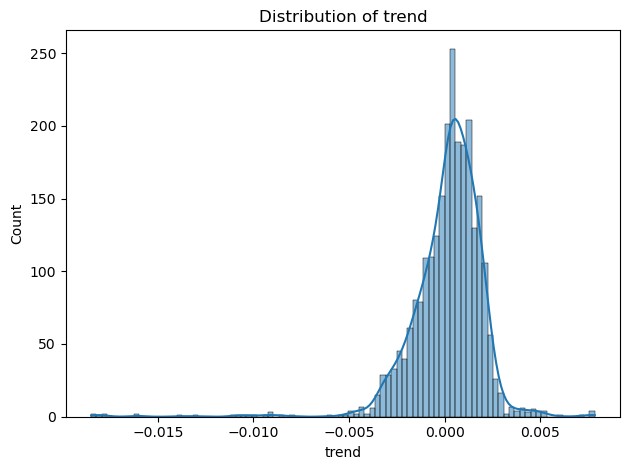

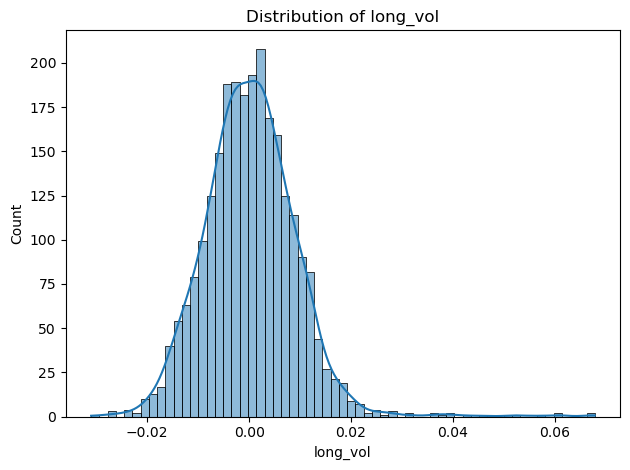

--------------------------------------------------------------------------------
Equity Styles Features:


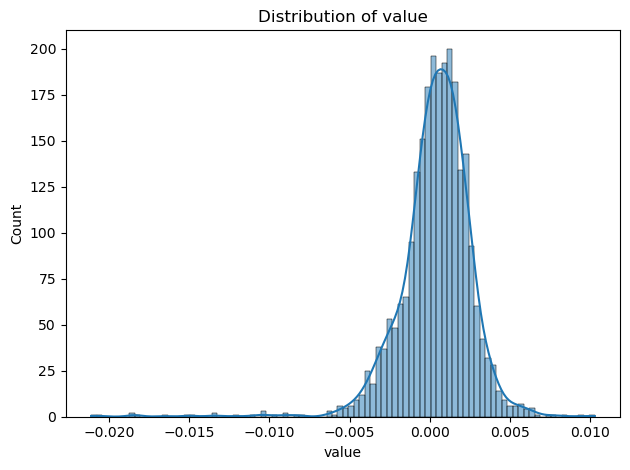

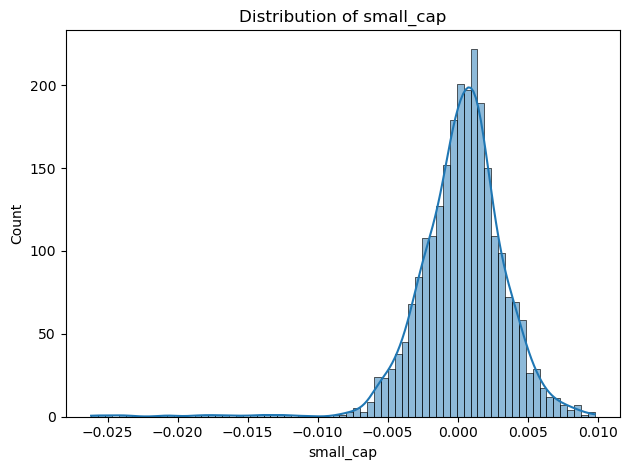

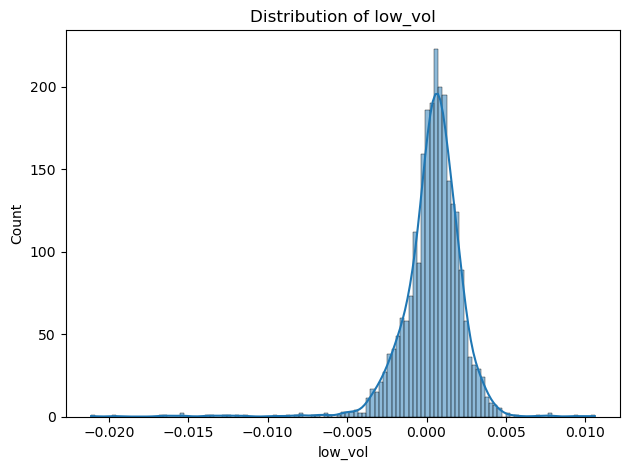

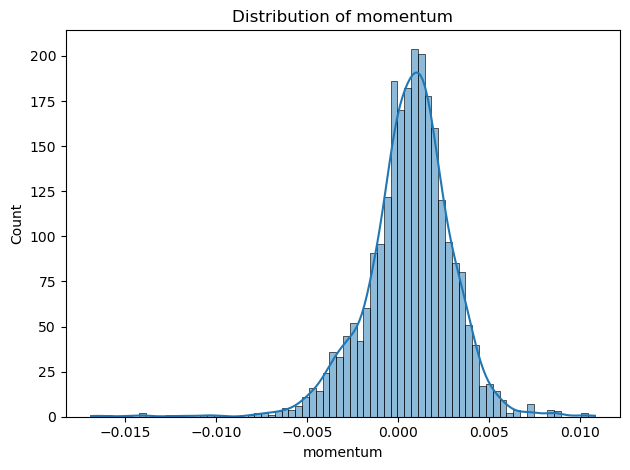

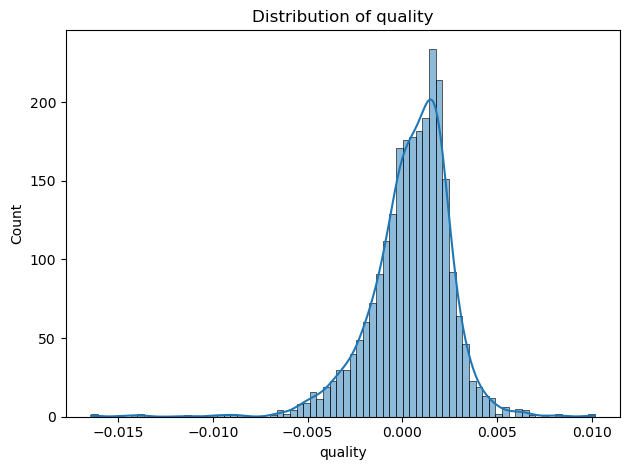

In [25]:
## Histogram of features

print("Macro Styles Features:")

# Macro_style Features
# get list of features in category
macro_styles_feats = []
for item in category_map.get("macro_styles"):
        macro_styles_feats.append(item)

# plot features in category
for feat in macro_styles_feats:
    if feat in return_df_20day.columns:
        sns.histplot(return_df_20day[feat], kde=True)
        plt.title(f"Distribution of {feat}")
        plt.tight_layout()
        plt.show()

print('-' * 80)
print("Equity Styles Features:")

# Equity_style Features
# get list of features in category
equity_styles_feats = []
for item in category_map.get("equity_styles"):
        equity_styles_feats.append(item)

# plot features in category
for feat in equity_styles_feats:
    if feat in return_df_20day.columns:
        sns.histplot(return_df_20day[feat], kde=True)
        plt.title(f"Distribution of {feat}")
        plt.tight_layout()
        plt.show()

Histograms for features in the macro and equity style categories are plotted here so that we better asses their distributions (compared to the pairplot).

All features have already been log transformed in the data processing notebook, and have had a 20-day rolling means applied.

With the 20 day rolling window, we still see roughly normal shapes for all features but now have much less skew compared to our daily returns data. Like mentioned in the other eda notebook, our GMM model can handle some skew via multiple components.

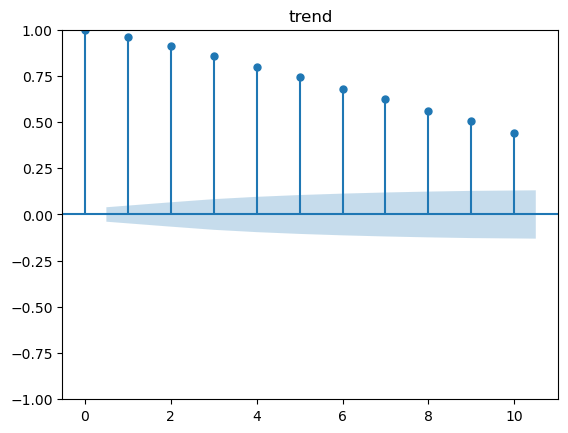

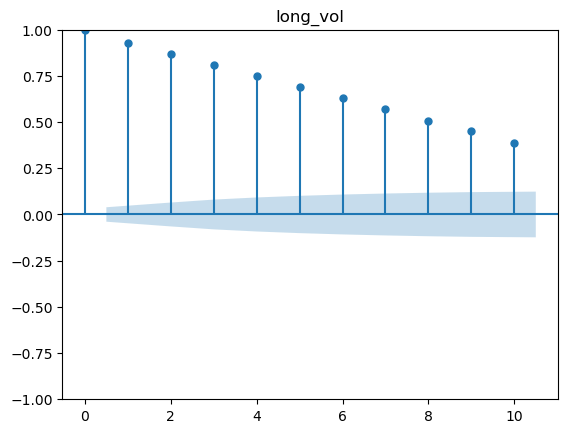

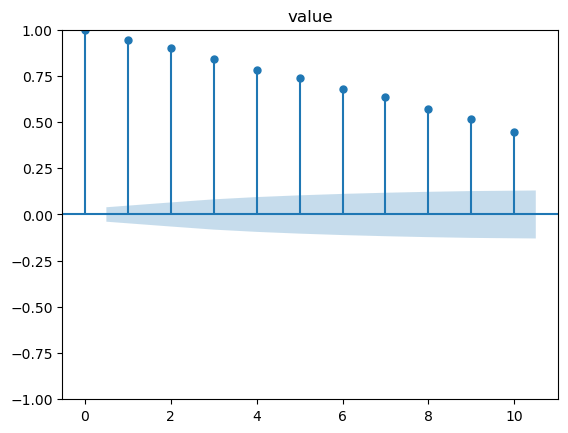

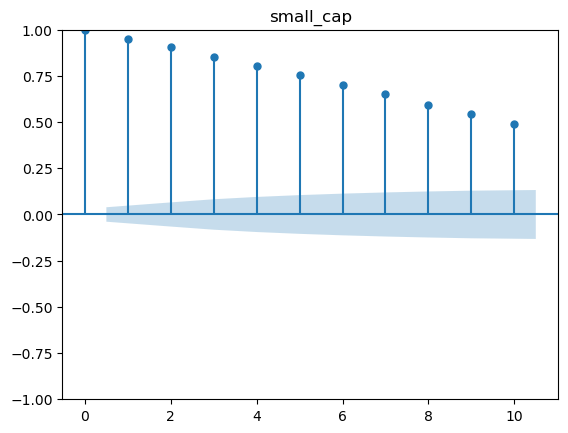

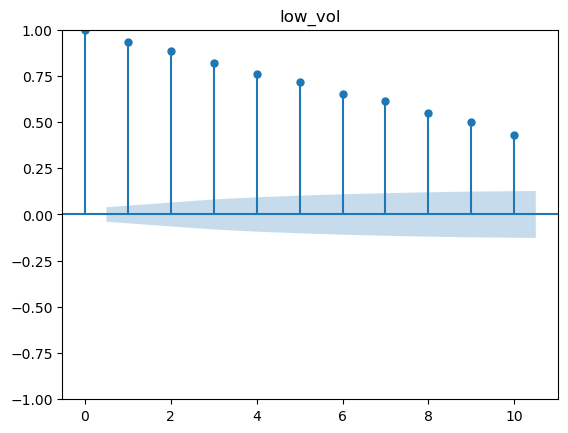

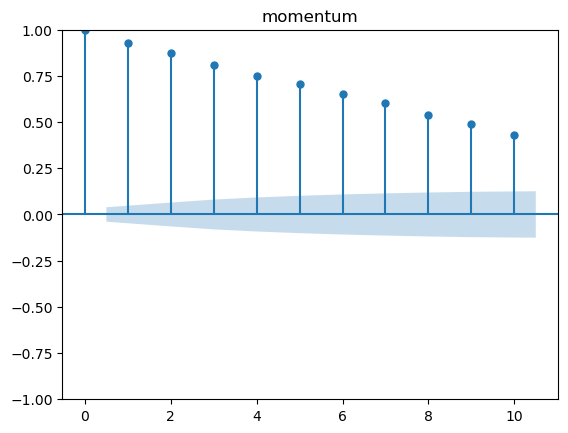

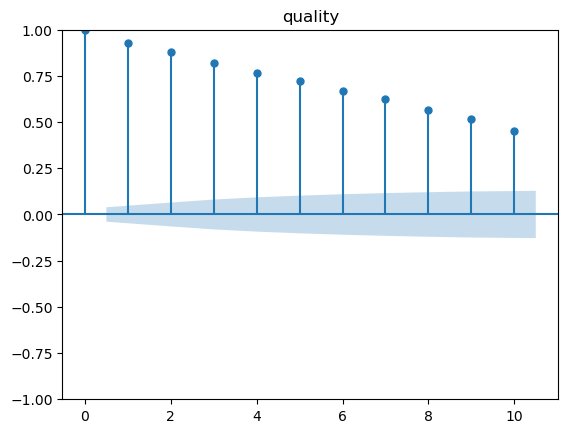

In [26]:
from statsmodels.graphics.tsaplots import plot_acf


for feat in macro_styles_feats:
    if feat in return_df_20day.columns:
        plot_acf(return_df_20day[feat].dropna(), lags=10)
        plt.title(f"{feat}")
        plt.show()

for feat in equity_styles_feats:
    if feat in return_df_20day.columns:
        plot_acf(return_df_20day[feat].dropna(), lags=10)
        plt.title(f"{feat}")
        plt.show()

Autocorrelation graphs can help detect serial dependence in our features.

Applying our rolling 20 day window means on returns would increase the severity of auto-correlation as we see here. Compared to the daily returns data, we have strong serial dependence due to smoothing of our data points.
IF we choose to go with 20 day rolling windows for the sake of detecting regimes on a longer scale, we may need to accept the violation of i.i.d, but use robust covariance estimations and evaluate the output of our GMM model with the context of time-dependence.